In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
ridership_df = pd.read_csv(
    "MTA_Subway_Origin-Destination_Ridership_Estimate__2024_20241008.csv"
)
stations_df = pd.read_csv("MTA_Subway_Stations_updated.csv")

In [3]:
ridership_df = ridership_df.drop(
    columns=[
        "Year",
        "Month",
        "Origin Station Complex Name",
        "Destination Station Complex Name",
        "Origin Latitude",
        "Origin Longitude",
        "Destination Latitude",
        "Destination Longitude",
        "Origin Point",
        "Destination Point",
    ]
)
ridership_df.head()

,Day of Week,Hour of Day,Timestamp,Origin Station Complex ID,Destination Station Complex ID,Estimated Average Ridership
0,Monday,1,01/08/2024 01:00:00 AM,26,355,0.5556
1,Monday,1,01/08/2024 01:00:00 AM,231,284,0.3068
2,Monday,1,01/08/2024 01:00:00 AM,313,71,0.3012
3,Monday,1,01/08/2024 01:00:00 AM,320,309,0.9000
4,Monday,1,01/08/2024 01:00:00 AM,399,618,0.2940


In [4]:
stations_df = stations_df.drop(
    columns=[
        "Division",
        "Line",
        "North Direction Label",
        "South Direction Label",
        "ADA Northbound",
        "ADA Southbound",
        "ADA Notes",
        "Georeference",
    ]
)
stations_df.head()

,GTFS Stop ID,Station ID,Complex ID,Stop Name,Borough,CBD,Daytime Routes,Structure,GTFS Latitude,GTFS Longitude,ADA
0,R01,1,1,Astoria-Ditmars Blvd,Q,False,N W,Elevated,40.775036,-73.912034,0
1,R03,2,2,Astoria Blvd,Q,False,N W,Elevated,40.770258,-73.917843,1
2,R04,3,3,30 Av,Q,False,N W,Elevated,40.766779,-73.921479,0
3,R05,4,4,Broadway,Q,False,N W,Elevated,40.761820,-73.925508,0
4,R06,5,5,36 Av,Q,False,N W,Elevated,40.756804,-73.929575,0


In [5]:
ridership_df.dtypes

Day of Week                        object
Hour of Day                         int64
Timestamp                          object
Origin Station Complex ID           int64
Destination Station Complex ID      int64
Estimated Average Ridership       float64
dtype: object

In [6]:
stations_df.dtypes

GTFS Stop ID       object
Station ID          int64
Complex ID          int64
Stop Name          object
Borough            object
CBD                  bool
Daytime Routes     object
Structure          object
GTFS Latitude     float64
GTFS Longitude    float64
ADA                 int64
dtype: object

Directed: trip from one station to another w direction

Weighted: weight representing average ridership

Self-loops: idk

In [8]:
G = nx.DiGraph()

# Initialize the graph with nodes
for index, row in stations_df.iterrows():
    G.add_node(
        row["Complex ID"],
        name=row["Stop Name"],
        borough=row["Borough"],
        ADA=row["ADA"],
        latitude=row["GTFS Latitude"],
        longitude=row["GTFS Longitude"],
    )

# Add edges incrementally, but store ridership as a list of dictionaries to keep all trip details
for _, row in ridership_df.iterrows():
    origin = row["Origin Station Complex ID"]
    destination = row["Destination Station Complex ID"]

    # If the edge already exists, append the new trip details to the list
    if G.has_edge(origin, destination):
        G[origin][destination]["trips"].append(
            {
                "ridership": row["Estimated Average Ridership"],
                "day_of_week": row["Day of Week"],
                "hour_of_day": row["Hour of Day"],
            }
        )
    else:
        # If the edge doesn't exist, create it and add the first trip
        G.add_edge(
            origin,
            destination,
            trips=[
                {
                    "ridership": row["Estimated Average Ridership"],
                    "day_of_week": row["Day of Week"],
                    "hour_of_day": row["Hour of Day"],
                }
            ],
        )

In [9]:
print(G)


DiGraph with 445 nodes and 174488 edges


In [10]:
unique_nodes_count = stations_df["Complex ID"].nunique()
unique_nodes_count

445

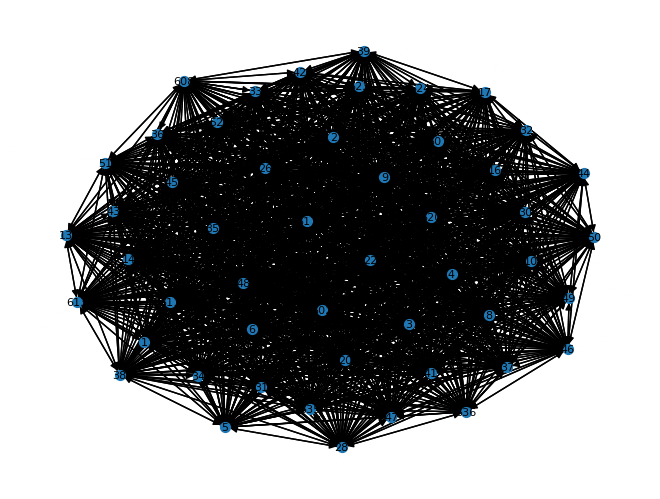

In [11]:
subgraph_nodes = list(G.nodes())[:50]
subgraph = G.subgraph(subgraph_nodes)

nx.draw(subgraph, with_labels=True, node_size=50, font_size=8)
plt.show()

In [12]:
aggregated_stations = {}

for u, v, data in G.edges(data=True):
    if u not in aggregated_stations:
        aggregated_stations[u] = 0

    for trip in data["trips"]:
        aggregated_stations[u] += trip["ridership"]

top_5_stations = sorted(aggregated_stations.items(), key=lambda x: x[1], reverse=True)[
    :5
]

top_5_stations

[(611, 772832.8064999951),
 (610, 578428.9966000087),
 (607, 421029.6783999983),
 (602, 382816.6319999976),
 (164, 332532.6990000031)]

In [13]:
aggregated_routes = []

for u, v, data in G.edges(data=True):
    total_ridership = sum(trip["ridership"] for trip in data["trips"])
    aggregated_routes.append((u, v, total_ridership))

top_5_routes = sorted(aggregated_routes, key=lambda x: x[2], reverse=True)[:5]

top_5_routes

[(610, 628, 27816.9111),
 (628, 610, 26933.6357),
 (611, 610, 23610.6667),
 (610, 611, 23032.0468),
 (610, 602, 21768.323)]

In [14]:
# Check
origin_ridership = ridership_df.groupby("Origin Station Complex ID")[
    "Estimated Average Ridership"
].sum()

top_5_origins = origin_ridership.sort_values(ascending=False).head(5)
print(top_5_origins)

Origin Station Complex ID
611    772832.8065
610    578428.9966
607    421029.6784
602    382816.6320
164    332532.6990
Name: Estimated Average Ridership, dtype: float64


In [15]:
destination_ridership = ridership_df.groupby("Destination Station Complex ID")[
    "Estimated Average Ridership"
].sum()

top_5_destinations = destination_ridership.sort_values(ascending=False).head(5)
print(top_5_destinations)

Destination Station Complex ID
611    755731.0109
610    553936.6710
607    427831.4631
602    408713.8706
628    324693.1087
Name: Estimated Average Ridership, dtype: float64


In [16]:
routes_ridership = ridership_df.groupby(
    ["Origin Station Complex ID", "Destination Station Complex ID"]
)["Estimated Average Ridership"].sum()

top_5_routes = routes_ridership.sort_values(ascending=False).head(5)
print(top_5_routes)

Origin Station Complex ID  Destination Station Complex ID
610                        628                               27816.9111
628                        610                               26933.6357
611                        610                               23610.6667
610                        611                               23032.0468
                           602                               21768.3230
Name: Estimated Average Ridership, dtype: float64


In [17]:
# 1a

for borough in ["M", "Bk", "Q", "Bx", "SI"]:
    borough_nodes = [n for n, d in G.nodes(data=True) if d["borough"] == borough]

    borough_subgraph = G.subgraph(borough_nodes)

    aggregated_ridership = {}

    for u, v, data in borough_subgraph.edges(data=True):
        if u not in aggregated_ridership:
            aggregated_ridership[u] = 0
        
        for trip in data["trips"]:
            aggregated_ridership[u] += trip["ridership"]

    top_5_origins = sorted(aggregated_ridership.items(), key=lambda x: x[1], reverse=True)[:5]

    print(f"Top 5 origin stations in {borough}: {top_5_origins}")


Top 5 origin stations in M: [(611, 492022.89099999913), (610, 375744.056100002), (607, 223684.46730000057), (164, 219993.4277999995), (318, 212053.69609999945)]
Top 5 origin stations in Bk: [(617, 101892.60109999987), (636, 55409.06489999984), (620, 44169.229199999856), (51, 39286.06430000029), (345, 38693.42919999978)]
Top 5 origin stations in Q: [(447, 115028.43759999995), (616, 106116.53660000024), (450, 49340.885699999926), (451, 47856.67200000009), (279, 42665.570400000215)]
Top 5 origin stations in Bx: [(604, 20482.494199999943), (434, 18945.420700000046), (371, 13748.588000000156), (366, 13551.495300000042), (382, 12690.52100000005)]
Top 5 origin stations in SI: []


In [ ]:
M: [(611, 492022.89099999913), (610, 375744.056100002), (607, 223684.46730000057), (164, 219993.4277999995), (318, 212053.69609999945)]
Bk: [(617, 101892.60109999987), (636, 55409.06489999984), (620, 44169.229199999856), (51, 39286.06430000029), (345, 38693.42919999978)]
Q: [(447, 115028.43759999995), (616, 106116.53660000024), (450, 49340.885699999926), (451, 47856.67200000009), (279, 42665.570400000215)]
Bx: [(604, 20482.494199999943), (434, 18945.420700000046), (371, 13748.588000000156), (366, 13551.495300000042), (382, 12690.52100000005)]
SI: []

In [18]:
staten_island_nodes = [n for n, d in G.nodes(data=True) if d["borough"] == "SI"]
len(staten_island_nodes)

for node in staten_island_nodes:
    print(
        f"Station ID: {node}, Out-degree (ridership): {G.out_degree(node, weight='ridership')}"
    )

Station ID: 501, Out-degree (ridership): 0
Station ID: 502, Out-degree (ridership): 0
Station ID: 503, Out-degree (ridership): 0
Station ID: 504, Out-degree (ridership): 0
Station ID: 505, Out-degree (ridership): 0
Station ID: 506, Out-degree (ridership): 0
Station ID: 507, Out-degree (ridership): 0
Station ID: 508, Out-degree (ridership): 0
Station ID: 509, Out-degree (ridership): 0
Station ID: 510, Out-degree (ridership): 0
Station ID: 511, Out-degree (ridership): 0
Station ID: 512, Out-degree (ridership): 0
Station ID: 513, Out-degree (ridership): 0
Station ID: 514, Out-degree (ridership): 0
Station ID: 515, Out-degree (ridership): 0
Station ID: 516, Out-degree (ridership): 0
Station ID: 517, Out-degree (ridership): 0
Station ID: 518, Out-degree (ridership): 0
Station ID: 519, Out-degree (ridership): 0
Station ID: 522, Out-degree (ridership): 0
Station ID: 523, Out-degree (ridership): 0


In [19]:
staten_island_origin = [
    501,
    502,
    503,
    504,
    505,
    506,
    507,
    508,
    509,
    510,
    511,
    512,
    513,
    514,
    515,
    516,
    517,
    518,
    519,
    522,
    523,
]
staten_island_ridership = ridership_df[
    ridership_df["Origin Station Complex ID"].isin(staten_island_origin)
]

len(staten_island_ridership)

0

In [20]:
staten_island_dest_ridership = ridership_df[
    ridership_df["Destination Station Complex ID"].isin(staten_island_origin)
]

len(staten_island_dest_ridership)

0

Staten Island Borough not included in Origin/Destination

In [22]:
# 1b

aggregated_ridership = {}

for u, v, data in G.edges(data=True):
    if u not in aggregated_ridership:
        aggregated_ridership[u] = 0

    for trip in data["trips"]:
        if trip["day_of_week"] in ["Monday", "Tuesday", "Wednesday"]:
            aggregated_ridership[u] += trip["ridership"]

top_5_origins_mtw = sorted(
    aggregated_ridership.items(), key=lambda x: x[1], reverse=True
)[:5]

top_5_origins_mtw

[(611, 366682.6977999996),
 (610, 299994.9464000017),
 (607, 198093.2732000026),
 (602, 178115.10260000048),
 (628, 158768.42939999944)]

In [23]:
# 1c

aggregated_ridership = {}

for u, v, data in G.edges(data=True):
    if u not in aggregated_ridership:
        aggregated_ridership[u] = 0

    for trip in data["trips"]:
        if trip["day_of_week"] in ["Saturday", "Sunday"]:
            aggregated_ridership[u] += trip["ridership"]

top_5_origins_ss = sorted(
    aggregated_ridership.items(), key=lambda x: x[1], reverse=True
)[:5]

top_5_origins_ss

[(611, 151484.71489999993),
 (607, 81496.3893000002),
 (610, 78418.81549999978),
 (602, 77392.21219999992),
 (164, 69408.95950000006)]

In [24]:
# 1d

aggregated_ridership = {}

for u, v, data in G.edges(data=True):
    if u not in aggregated_ridership:
        aggregated_ridership[u] = 0
    for trip in data["trips"]:
        if 1 <= trip["hour_of_day"] <= 5:
            aggregated_ridership[u] += trip["ridership"]

top_5_origins_night = sorted(
    aggregated_ridership.items(), key=lambda x: x[1], reverse=True
)[:5]

top_5_origins_night

[(611, 23851.845899999837),
 (616, 14400.297700000001),
 (447, 11501.979899999966),
 (450, 11346.55689999999),
 (278, 8971.765100000013)]

In [25]:
# Check
filtered_df = ridership_df[
    (ridership_df["Hour of Day"] >= 1) & (ridership_df["Hour of Day"] <= 5)
]

origin_ridership = filtered_df.groupby("Origin Station Complex ID")[
    "Estimated Average Ridership"
].sum()

top_5_origins_df = origin_ridership.sort_values(ascending=False).head(5)

top_5_origins_df

Origin Station Complex ID
611    23851.8459
616    14400.2977
447    11501.9799
450    11346.5569
278     8971.7651
Name: Estimated Average Ridership, dtype: float64

In [50]:
# 1e

# 6am to 9am across all days and boroughs

aggregated_ridership = {}

for u, v, data in G.edges(data=True):
    if u not in aggregated_ridership:
        aggregated_ridership[u] = 0
    for trip in data["trips"]:
        if 6 <= trip["hour_of_day"] <= 9:
            aggregated_ridership[u] += trip["ridership"]

top_5_origins_6to9 = sorted(
    aggregated_ridership.items(), key=lambda x: x[1], reverse=True
)[:5]

top_5_origins_6to9

[(611, 173476.38119999933),
 (610, 120589.19049999968),
 (616, 89547.93639999963),
 (318, 86708.27519999936),
 (447, 84534.1125000009)]

In [54]:
# Check again
filtered_df = ridership_df[
    (ridership_df["Hour of Day"] >= 6) & (ridership_df["Hour of Day"] <= 9)
]

origin_ridership = filtered_df.groupby("Origin Station Complex ID")[
    "Estimated Average Ridership"
].sum()

top_5_origins_df2 = origin_ridership.sort_values(ascending=False).head(5)

top_5_origins_df2

Origin Station Complex ID
611    173476.3812
610    120589.1905
616     89547.9364
318     86708.2752
447     84534.1125
Name: Estimated Average Ridership, dtype: float64

In [56]:
# Start of question 2

stations_df

,GTFS Stop ID,Station ID,Complex ID,Stop Name,Borough,CBD,Daytime Routes,Structure,GTFS Latitude,GTFS Longitude,ADA
0,R01,1,1,Astoria-Ditmars Blvd,Q,False,N W,Elevated,40.775036,-73.912034,0
1,R03,2,2,Astoria Blvd,Q,False,N W,Elevated,40.770258,-73.917843,1
2,R04,3,3,30 Av,Q,False,N W,Elevated,40.766779,-73.921479,0
3,R05,4,4,Broadway,Q,False,N W,Elevated,40.761820,-73.925508,0
4,R06,5,5,36 Av,Q,False,N W,Elevated,40.756804,-73.929575,0
...,...,...,...,...,...,...,...,...,...,...,...
491,S15,517,517,Prince's Bay,SI,False,SIR,Open Cut,40.525507,-74.200064,0
492,S14,518,518,Pleasant Plains,SI,False,SIR,Embankment,40.522410,-74.217847,0
493,S13,519,519,Richmond Valley,SI,False,SIR,Open Cut,40.519631,-74.229141,0
494,S09,522,522,Tottenville,SI,False,SIR,At Grade,40.512764,-74.251961,1


In [58]:
ridership_df

,Day of Week,Hour of Day,Timestamp,Origin Station Complex ID,Destination Station Complex ID,Estimated Average Ridership
0,Monday,1,01/08/2024 01:00:00 AM,26,355,0.5556
1,Monday,1,01/08/2024 01:00:00 AM,231,284,0.3068
2,Monday,1,01/08/2024 01:00:00 AM,313,71,0.3012
3,Monday,1,01/08/2024 01:00:00 AM,320,309,0.9000
4,Monday,1,01/08/2024 01:00:00 AM,399,618,0.2940
...,...,...,...,...,...,...
9169120,Sunday,12,01/14/2024 12:00:00 PM,426,379,0.3322
9169121,Sunday,12,01/14/2024 12:00:00 PM,427,613,0.7305
9169122,Sunday,12,01/14/2024 12:00:00 PM,32,263,0.3130
9169123,Sunday,12,01/14/2024 12:00:00 PM,324,407,0.8602


In [193]:
# 2a
for borough in ["M", "Bk", "Q", "Bx", "SI"]:
    borough_nodes = [n for n, d in G.nodes(data=True) if d["borough"] == borough]

    borough_subgraph = G.subgraph(borough_nodes)

    aggregated_ridership = {}

    for u, v, data in borough_subgraph.edges(data=True):
        if v not in aggregated_ridership:
            aggregated_ridership[v] = 0
        
        for trip in data["trips"]:
            aggregated_ridership[v] += trip["ridership"]

    top_5_destinations = sorted(aggregated_ridership.items(), key=lambda x: x[1], reverse=True)[:5]

    print(f"Top 5 destination stations in {borough}: {top_5_destinations}")

Top 5 destination stations in M: [(611, 474085.95449999993), (610, 344473.241499999), (607, 224767.6016999997), (602, 214544.4496000014), (614, 202620.20410000192)]
Top 5 destination stations in Bk: [(617, 103014.17409999992), (636, 61373.84730000002), (620, 49045.45229999993), (120, 41980.954599999925), (51, 38973.033599999886)]
Top 5 destination stations in Q: [(616, 108329.40600000016), (447, 107684.79850000006), (450, 48124.09640000009), (451, 45009.05699999996), (261, 42103.076000000045)]
Top 5 destination stations in Bx: [(604, 20726.217900000065), (434, 18685.011900000067), (366, 13192.732900000037), (371, 12729.468700000025), (603, 12475.006900000006)]
Top 5 destination stations in SI: []


In [197]:
# 2b
aggregated_ridership = {}

for u, v, data in G.edges(data=True):
    if v not in aggregated_ridership:
        aggregated_ridership[v] = 0

    for trip in data["trips"]:
        if trip["day_of_week"] in ["Thursday", "Friday"]:
            aggregated_ridership[v] += trip["ridership"]

top_5_destinations_tf = sorted(
    aggregated_ridership.items(), key=lambda x: x[1], reverse=True
)[:5]

top_5_destinations_tf

[(611, 254027.9514999997),
 (610, 193929.8707),
 (607, 146122.45520000084),
 (602, 137625.25149999914),
 (628, 112550.08569999952)]

In [201]:
# 2c
aggregated_ridership = {}

for u, v, data in G.edges(data=True):
    if v not in aggregated_ridership:
        aggregated_ridership[v] = 0

    for trip in data["trips"]:
        if trip["day_of_week"] in ["Saturday"]:
            aggregated_ridership[v] += trip["ridership"]

top_5_origins_sat = sorted(
    aggregated_ridership.items(), key=lambda x: x[1], reverse=True
)[:5]

top_5_origins_sat

[(611, 82215.39059999987),
 (607, 48560.38809999996),
 (602, 48271.31670000008),
 (610, 40886.469899999924),
 (164, 35605.25350000009)]

In [92]:
sorted(ridership_df['Hour of Day'].unique())

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23]

In [221]:
# 2d
# Between 12am-5am across all days and boroughs

aggregated_ridership = {}

for u, v, data in G.edges(data=True):
    if v not in aggregated_ridership:
        aggregated_ridership[v] = 0
    for trip in data["trips"]:
        if 0 <= trip["hour_of_day"] <= 5:
            aggregated_ridership[v] += trip["ridership"]

top_5_destinations_midnight_to_morning = sorted(
    aggregated_ridership.items(), key=lambda x: x[1], reverse=True
)[:5]

top_5_destinations_midnight_to_morning

[(611, 24700.964199999948),
 (610, 19211.66700000001),
 (607, 13386.72769999996),
 (616, 12220.43559999997),
 (628, 12128.324100000027)]

In [223]:
# Check again for 12am to 5am
filtered_df = ridership_df[
    (ridership_df["Hour of Day"] >= 0) & (ridership_df["Hour of Day"] <= 5)
]

destination_ridership = filtered_df.groupby("Destination Station Complex ID")[
    "Estimated Average Ridership"
].sum()

top_5_destinations_df = destination_ridership.sort_values(ascending=False).head(5)

top_5_destinations_df

Destination Station Complex ID
611    24700.9642
610    19211.6670
607    13386.7277
616    12220.4356
628    12128.3241
Name: Estimated Average Ridership, dtype: float64

In [225]:
# 2e
# Between 6pm-9pm across all days and boroughs
aggregated_ridership = {}

for u, v, data in G.edges(data=True):
    if v not in aggregated_ridership:
        aggregated_ridership[v] = 0
    for trip in data["trips"]:
        if 18 <= trip["hour_of_day"] <= 21:
            aggregated_ridership[v] += trip["ridership"]

top_5_destinations_dusk = sorted(
    aggregated_ridership.items(), key=lambda x: x[1], reverse=True
)[:5]

top_5_destinations_dusk

[(611, 130974.97279999986),
 (610, 67513.95080000036),
 (607, 63408.88060000024),
 (616, 62489.09310000007),
 (602, 60015.50270000017)]

In [227]:
# Check again for 6pm to 9pm
filtered_df = ridership_df[
    (ridership_df["Hour of Day"] >= 18) & (ridership_df["Hour of Day"] <= 21)
]

destination_ridership = filtered_df.groupby("Destination Station Complex ID")[
    "Estimated Average Ridership"
].sum()

top_5_destinations_df2 = destination_ridership.sort_values(ascending=False).head(5)

top_5_destinations_df2 # They are the same

Destination Station Complex ID
611    130974.9728
610     67513.9508
607     63408.8806
616     62489.0931
602     60015.5027
Name: Estimated Average Ridership, dtype: float64

In [334]:
# Start of question 3
# Monday between 1pm-2pm?

aggregated_ridership = {}

for u, v, data in G.edges(data=True):
    if (u,v) not in aggregated_ridership:
        aggregated_ridership[(u, v)] = 0

    for trip in data["trips"]:
        if (trip["day_of_week"] in ["Monday"]) and (13 <= trip["hour_of_day"] <= 14):
            aggregated_ridership[(u, v)] += trip["ridership"]

top_10_pairs_tf = sorted(
    aggregated_ridership.items(), key=lambda x: x[1], reverse=True
)[:10]

top_10_pairs_tf


[((610, 611), 282.2022),
 ((447, 450), 273.77160000000003),
 ((628, 610), 272.3798),
 ((447, 451), 271.3252),
 ((610, 602), 270.66179999999997),
 ((447, 616), 259.85699999999997),
 ((602, 610), 255.8078),
 ((451, 447), 239.9478),
 ((611, 610), 232.1258),
 ((610, 628), 231.0762)]

In [338]:
# question 3b 
# On Queens borough, on Fridays between 6pm-9pm?

for borough in ["Q"]:
    borough_nodes = [n for n, d in G.nodes(data=True) if d["borough"] == borough]

    borough_subgraph = G.subgraph(borough_nodes)

    aggregated_ridership = {}

    for u, v, data in borough_subgraph.edges(data=True):
        if (u,v) not in aggregated_ridership:
            aggregated_ridership[(u,v)] = 0
        
        for trip in data["trips"]:
            if (trip["day_of_week"] in ["Friday"]) and (18 <= trip["hour_of_day"] <= 21):
            
                aggregated_ridership[(u,v)] += trip["ridership"]

    top_10_queens = sorted(aggregated_ridership.items(), key=lambda x: x[1], reverse=True)[:10]

    print(f"Top 10 station pairs in {borough}: {top_10_queens}")

Top 10 station pairs in Q: [((447, 616), 645.8218), ((447, 450), 644.121), ((447, 451), 593.8203), ((451, 447), 433.6342), ((447, 452), 385.55960000000005), ((616, 447), 345.3137), ((450, 447), 278.0807), ((447, 449), 240.2326), ((453, 447), 235.28950000000003), ((616, 254), 222.0617)]


In [340]:
# question 3c

# On Brooklyn borough, Ridership between 1am-5am?
for borough in ["Bk"]:
    borough_nodes = [n for n, d in G.nodes(data=True) if d["borough"] == borough]

    borough_subgraph = G.subgraph(borough_nodes)

    aggregated_ridership = {}

    for u, v, data in borough_subgraph.edges(data=True):
        if (u,v) not in aggregated_ridership:
            aggregated_ridership[(u,v)] = 0
        
        for trip in data["trips"]:
            if (trip["day_of_week"] in ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]) and (1 <= trip["hour_of_day"] <= 5):
            
                aggregated_ridership[(u,v)] += trip["ridership"]

    top_10_brooklyn = sorted(aggregated_ridership.items(), key=lambda x: x[1], reverse=True)[:10]

    print(f"Top 10 station pairs in {borough}: {top_10_brooklyn}")

Top 10 station pairs in Bk: [((345, 617), 136.07070000000002), ((359, 617), 107.77689999999997), ((120, 630), 104.99919999999999), ((345, 620), 104.1418), ((630, 120), 93.29039999999999), ((345, 337), 92.5102), ((188, 636), 92.49589999999999), ((617, 32), 86.25559999999999), ((120, 127), 86.00580000000001), ((629, 630), 77.3768)]


In [277]:
#stations_df.groupby(station_df['Borough'] == 'Bk' )
stations_df_new = stations_df[stations_df['Borough'] == 'M']

In [299]:
stations_df_new.loc[stations_df_new['Station ID'] == 119]


,GTFS Stop ID,Station ID,Complex ID,Stop Name,Borough,CBD,Daytime Routes,Structure,GTFS Latitude,GTFS Longitude,ADA
118,L06,119,119,1 Av,M,True,L,Subway,40.730953,-73.981628,1


In [269]:

brooklyn_nodes = [n for n, d in G.nodes(data=True) if d["borough"] == "Bk"]
manhattan_nodes = [n for n, d in G.nodes(data=True) if d["borough"] == "M"]







In [271]:
brooklyn_nodes

[620,
 636,
 26,
 617,
 28,
 608,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 615,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 74,
 75,
 76,
 77,
 78,
 79,
 86,
 87,
 88,
 89,
 90,
 91,
 621,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 630,
 113,
 114,
 120,
 629,
 122,
 123,
 124,
 125,
 126,
 127,
 130,
 131,
 133,
 134,
 135,
 136,
 137,
 138,
 627,
 141,
 626,
 173,
 175,
 176,
 177,
 179,
 180,
 181,
 182,
 183,
 185,
 186,
 187,
 188,
 189,
 235,
 236,
 237,
 238,
 240,
 241,
 242,
 243,
 244,
 245,
 246,
 247,
 248,
 249,
 250,
 251,
 252,
 253,
 283,
 284,
 286,
 287,
 288,
 289,
 290,
 291,
 292,
 334,
 336,
 337,
 339,
 340,
 341,
 343,
 344,
 345,
 346,
 347,
 348,
 349,
 350,
 351,
 352,
 353,
 354,
 355,
 356,
 357,
 358,
 359]

In [273]:
manhattan_nodes

[613,
 8,
 9,
 10,
 611,
 607,
 13,
 14,
 602,
 16,
 17,
 623,
 20,
 624,
 22,
 635,
 625,
 103,
 622,
 628,
 107,
 618,
 601,
 118,
 119,
 143,
 144,
 145,
 146,
 147,
 605,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 614,
 162,
 164,
 165,
 167,
 168,
 169,
 220,
 222,
 223,
 224,
 225,
 609,
 228,
 619,
 231,
 232,
 234,
 612,
 276,
 277,
 296,
 297,
 298,
 299,
 300,
 301,
 303,
 304,
 305,
 306,
 307,
 308,
 309,
 310,
 311,
 312,
 313,
 314,
 316,
 318,
 319,
 320,
 321,
 323,
 324,
 325,
 326,
 327,
 328,
 329,
 333,
 392,
 393,
 394,
 395,
 396,
 397,
 398,
 399,
 610,
 403,
 404,
 405,
 407,
 409,
 413,
 414,
 436,
 437,
 438,
 439,
 440,
 441,
 471,
 475,
 476,
 477]

In [255]:
brooklyn_nodes = [n for n, d in G.nodes(data=True) if d["borough"] == "Bk"]
manhattan_nodes = [n for n, d in G.nodes(data=True) if d["borough"] == "M"]

brooklyn_nodes




[620,
 636,
 26,
 617,
 28,
 608,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 615,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 74,
 75,
 76,
 77,
 78,
 79,
 86,
 87,
 88,
 89,
 90,
 91,
 621,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 630,
 113,
 114,
 120,
 629,
 122,
 123,
 124,
 125,
 126,
 127,
 130,
 131,
 133,
 134,
 135,
 136,
 137,
 138,
 627,
 141,
 626,
 173,
 175,
 176,
 177,
 179,
 180,
 181,
 182,
 183,
 185,
 186,
 187,
 188,
 189,
 235,
 236,
 237,
 238,
 240,
 241,
 242,
 243,
 244,
 245,
 246,
 247,
 248,
 249,
 250,
 251,
 252,
 253,
 283,
 284,
 286,
 287,
 288,
 289,
 290,
 291,
 292,
 334,
 336,
 337,
 339,
 340,
 341,
 343,
 344,
 345,
 346,
 347,
 348,
 349,
 350,
 351,
 352,
 353,
 354,
 355,
 356,
 357,
 358,
 359]

In [323]:
# 3d

# Source is Brooklyn, Destination is Manhattan, Monday-Thursday 6am-7am?

brooklyn_nodes = [n for n, d in G.nodes(data=True) if d["borough"] == "Bk"]
manhattan_nodes = [n for n, d in G.nodes(data=True) if d["borough"] == "M"]

borough_nodes = [n for n, d in G.nodes(data=True) if (d["borough"] == "Bk" or d['borough'] == "M")]
    

borough_subgraph = G.subgraph(borough_nodes)

aggregated_ridership = {}

for u, v, data in borough_subgraph.edges(data=True):
        
    if borough_subgraph.nodes[u]['borough'] == "Bk" and borough_subgraph.nodes[v]['borough'] == "M":
            
        if (u,v) not in aggregated_ridership:
            aggregated_ridership[(u,v)] = 0
        
        for trip in data["trips"]:
            if (trip["day_of_week"] in ["Monday", "Tuesday", "Wednesday", "Thursday"]) and (6 <= trip["hour_of_day"] <= 7):
            
                aggregated_ridership[(u,v)] += trip["ridership"]

top_10_bk_to_m = sorted(aggregated_ridership.items(), key=lambda x: x[1], reverse=True)[:10]

print(f"Top 10 station pairs in from brooklyn to manhattan: {top_10_bk_to_m}")

Top 10 station pairs in from brooklyn to manhattan: [((617, 414), 1029.6122999999998), ((345, 610), 692.6152000000001), ((51, 607), 655.3457000000001), ((620, 610), 653.3663), ((359, 610), 589.2357), ((345, 628), 580.2716), ((359, 628), 557.0980999999999), ((120, 610), 555.5914), ((51, 225), 503.5513), ((54, 225), 478.5522)]


In [329]:
# 3e
bronx_nodes = [n for n, d in G.nodes(data=True) if d["borough"] == "Bx"]
manhattan_nodes = [n for n, d in G.nodes(data=True) if d["borough"] == "M"]

borough_nodes = [n for n, d in G.nodes(data=True) if (d["borough"] == "Bx" or d['borough'] == "M")]
    

borough_subgraph = G.subgraph(borough_nodes)

aggregated_ridership = {}

for u, v, data in borough_subgraph.edges(data=True):
        
    if borough_subgraph.nodes[u]['borough'] == "Bx" and borough_subgraph.nodes[v]['borough'] == "M":
            
        if (u,v) not in aggregated_ridership:
            aggregated_ridership[(u,v)] = 0
        
        for trip in data["trips"]:
            if (trip["day_of_week"] in ["Monday", "Tuesday", "Wednesday", "Thursday"]) and (6 <= trip["hour_of_day"] <= 7):
            
                aggregated_ridership[(u,v)] += trip["ridership"]

top_10_bx_to_m = sorted(aggregated_ridership.items(), key=lambda x: x[1], reverse=True)[:10]

print(f"Top 10 station pairs in from bronx to manhattan: {top_10_bx_to_m}")




Top 10 station pairs in from bronx to manhattan: [((366, 610), 562.2564), ((366, 602), 402.36749999999995), ((366, 392), 395.6825), ((366, 399), 383.7979), ((366, 397), 372.9343), ((366, 612), 357.86589999999995), ((366, 628), 346.6705), ((366, 622), 320.3933), ((604, 614), 306.00469999999996), ((378, 397), 302.63100000000003)]


In [331]:
# 3f

statenisland_nodes = [n for n, d in G.nodes(data=True) if d["borough"] == "SI"]
manhattan_nodes = [n for n, d in G.nodes(data=True) if d["borough"] == "M"]

borough_nodes = [n for n, d in G.nodes(data=True) if (d["borough"] == "SI" or d['borough'] == "M")]
    

borough_subgraph = G.subgraph(borough_nodes)

aggregated_ridership = {}

for u, v, data in borough_subgraph.edges(data=True):
        
    if borough_subgraph.nodes[u]['borough'] == "SI" and borough_subgraph.nodes[v]['borough'] == "M":
            
        if (u,v) not in aggregated_ridership:
            aggregated_ridership[(u,v)] = 0
        
        for trip in data["trips"]:
            if (trip["day_of_week"] in ["Monday", "Tuesday", "Wednesday", "Thursday"]) and (6 <= trip["hour_of_day"] <= 7):
            
                aggregated_ridership[(u,v)] += trip["ridership"]

top_10_si_to_m = sorted(aggregated_ridership.items(), key=lambda x: x[1], reverse=True)[:10]

print(f"Top 10 station pairs in from staten island to manhattan: {top_10_si_to_m}")


Top 10 station pairs in from staten island to manhattan: []
